# Seizure detection sandbox

## Workspace Preparation

In [2]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import minmax_scale
from kneed import KneeLocator

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for deep learning
import random
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
from seizure_detection_pipeline import *
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

2024-10-17 15:00:45.470931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 15:00:46.570650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
_,_,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [4]:
set_seed(5210)

In [5]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information_BIDS.csv"))
pt = 'HUP266'
montage = 'bipolar'

## Anomaly Detection

### Generating model predictions

(<Figure size 1999.93x2460 with 1 Axes>, <Axes: xlabel='Time (s)'>)

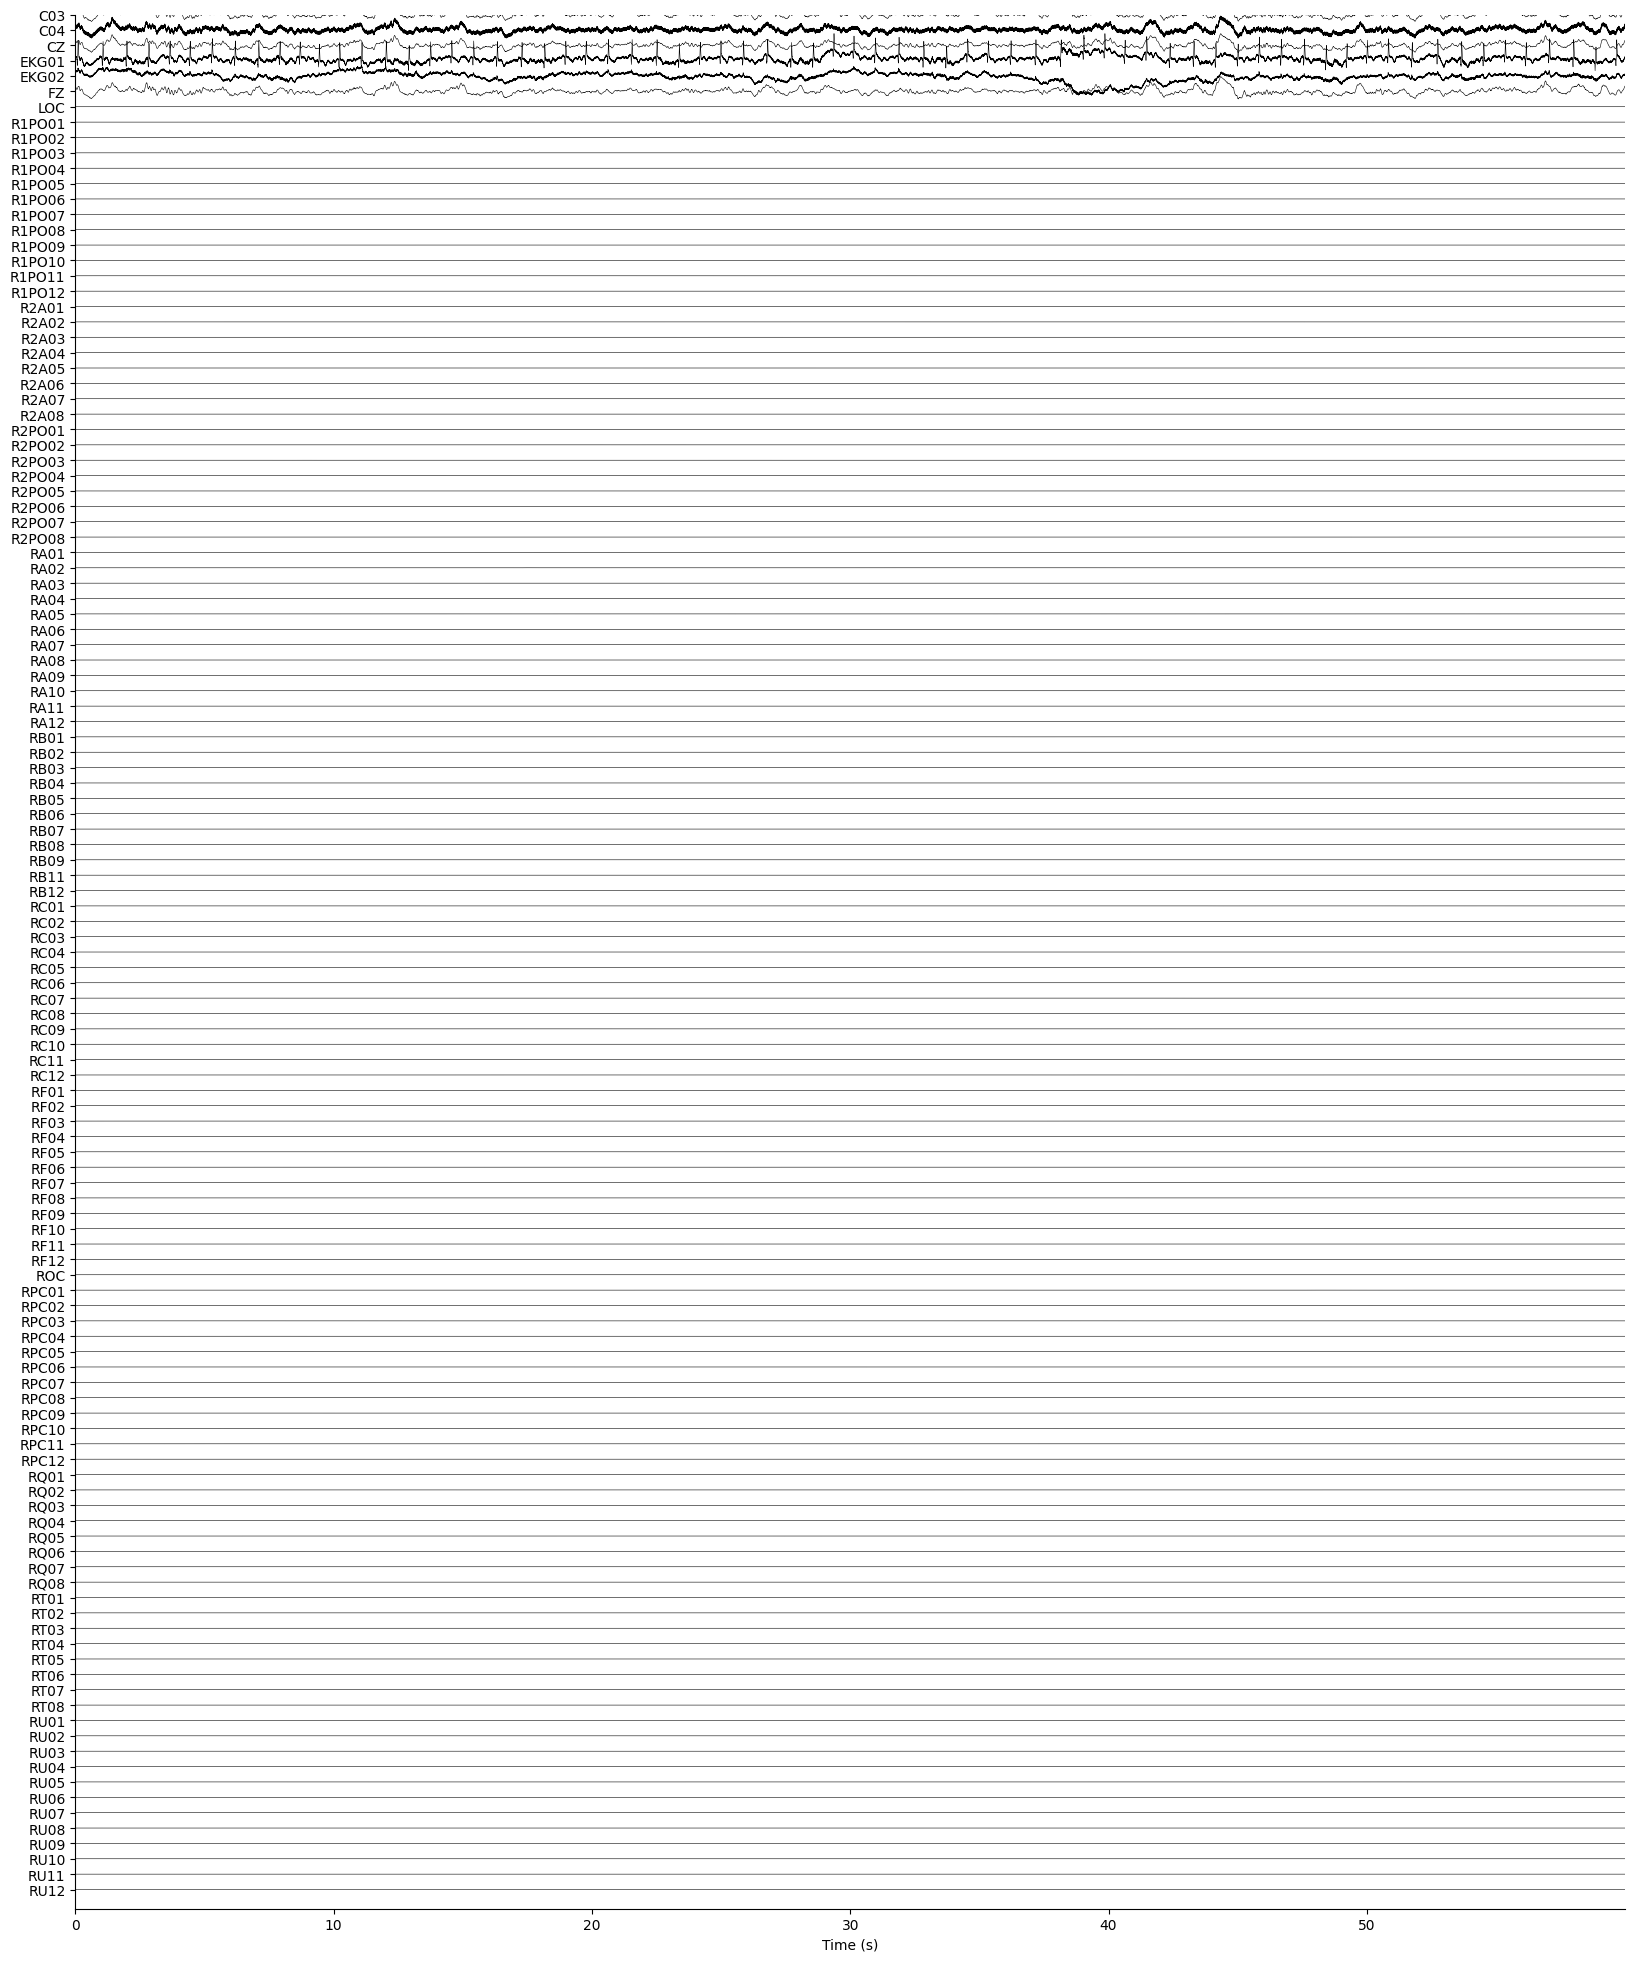

In [6]:
# Loading data from bids
inter,fs_raw = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [7]:
def remove_scalp_electrodes(raw_labels):
    scalp_list = ['CZ','FZ','PZ',
                  'A01','A02',
                  'C03','C04',
                  'F03','F04','F07','F08',
                  'Fp01','Fp02',
                  'O01','O02',
                  'P03','P04',
                  'T03','T04','T05','T06',
                  'EKG01','EKG02',
                  'ROC','LOC',
                  'EMG01','EMG02',
                  'DC01','DC07'
                  ]
    chop_scalp = ['C1'+str(x) for x in range(19,29)]
    scalp_list += chop_scalp
    return [l for l in raw_labels if l.upper() not in scalp_list]

In [8]:
# Pruning channels
chn_labels = remove_scalp_electrodes(inter.columns)
inter_raw = inter[chn_labels]
# plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [9]:
electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
if pt[:3] == 'CHO':
    suffix = ['CHOPR','CHOPM']
else:
    suffix = ['dkt','atropos']
electrode_localizations.name = clean_labels(electrode_localizations.name,pt) #don't end up using grey/white matter
electrode_regions.name = clean_labels(electrode_regions.name,pt)
electrode_localizations.to_pickle(ospj(prodatapath,pt,f'electrode_localizations_{suffix[1]}.pkl')) #don't end up using grey/white matter
electrode_regions.to_pickle(ospj(prodatapath,pt,f'electrode_localizations_{suffix[0]}.pkl'))
neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter_raw.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
inter_neural = inter_raw[neural_channels]

In [10]:
# inter_neural.iloc[:,:22] = inter_neural.iloc[:,:22]*1e-3

In [11]:
inter_prep,fs,mask = preprocess_for_detection(inter_neural,fs_raw,wavenet=False,target=128)

(<Figure size 1999.93x1560 with 1 Axes>, <Axes: xlabel='Time (s)'>)

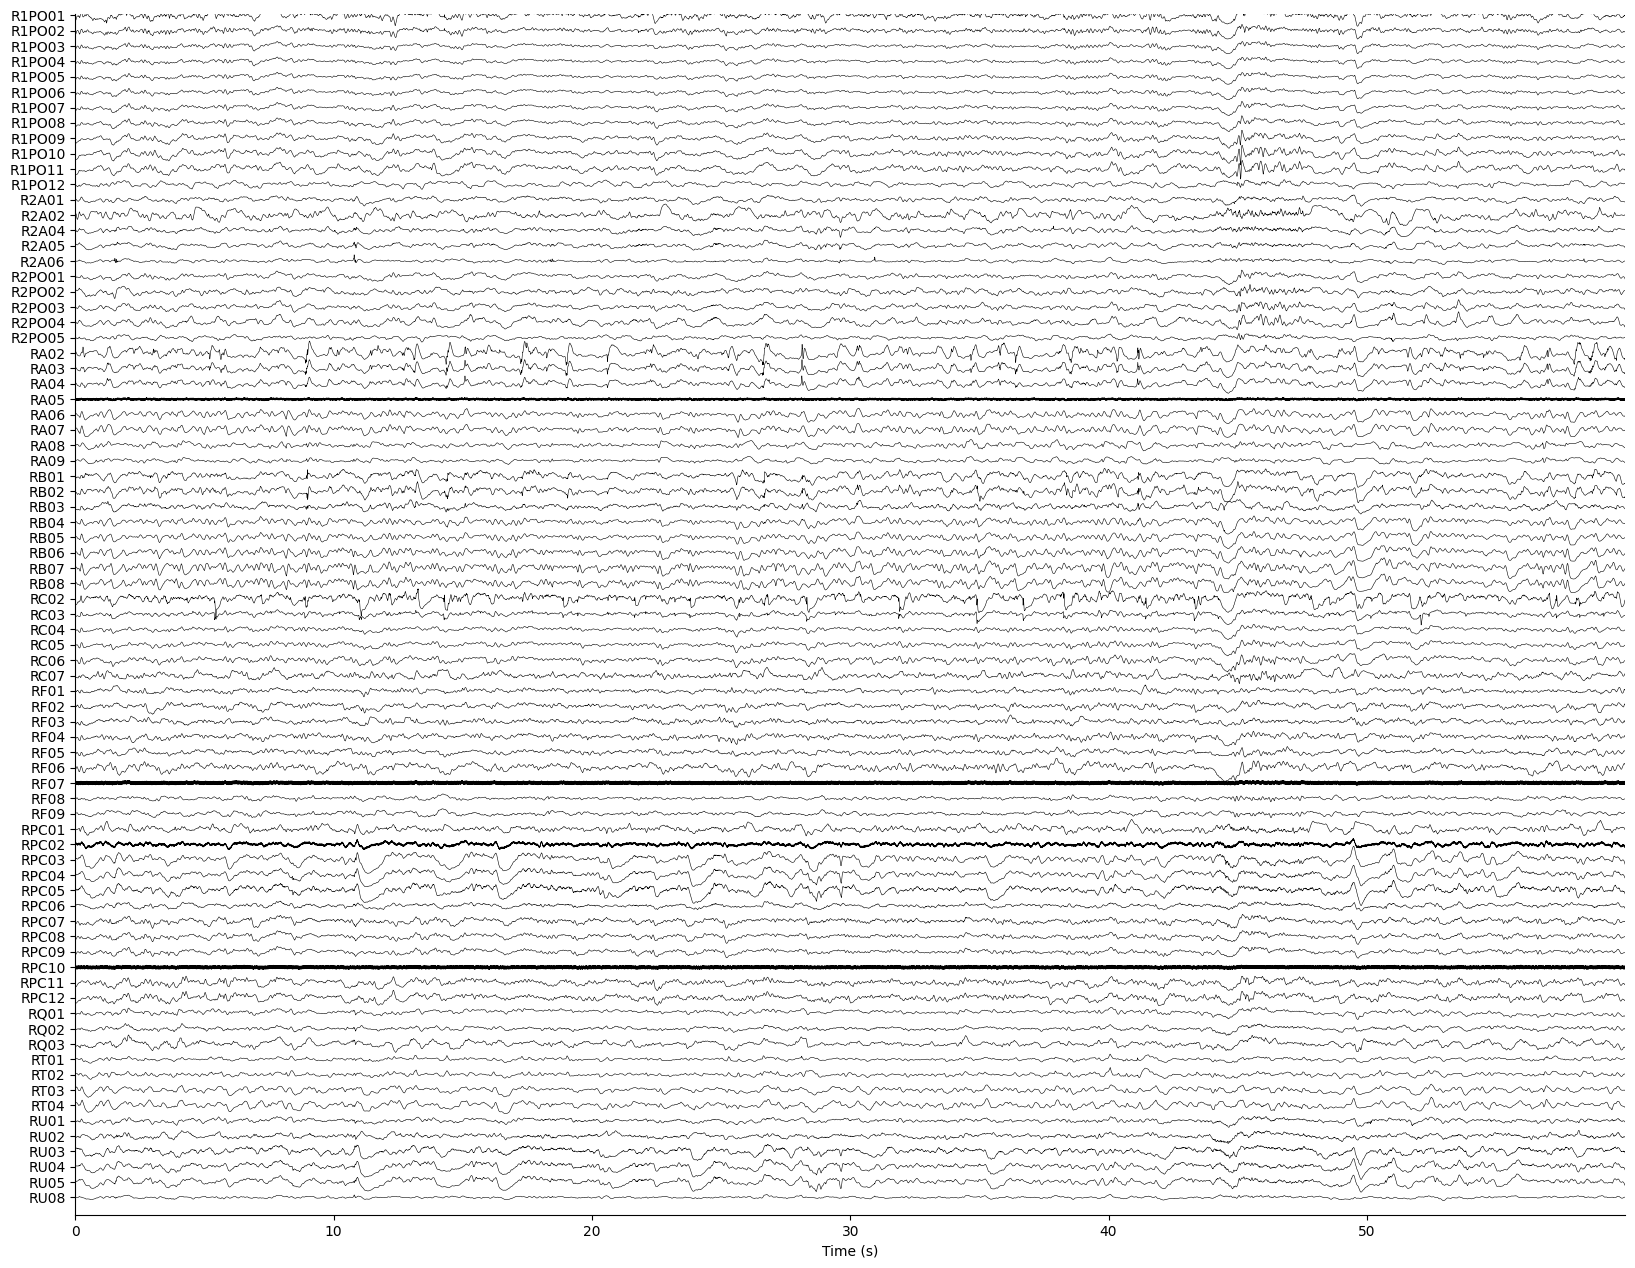

In [12]:
plot_iEEG_data(inter_neural,np.arange(len(inter_neural))/fs_raw)

In [13]:
model= AbsSlope(1,.5,128)
model.fit(inter_prep)

In [14]:
# plot_iEEG_data(model.inter,np.arange(len(model.inter))/fs)

In [15]:
seizure_times = seizures_df[seizures_df.Patient == pt]
qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
for i,(_,sz_row) in enumerate(qbar):
    set_seed(1071999)
    if i <=2:
        continue
    # Load in seizure and metadata for BIDS path
    seizure_raw,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
    break

(<Figure size 9366.6x1560 with 1 Axes>, <Axes: xlabel='Time (s)'>)

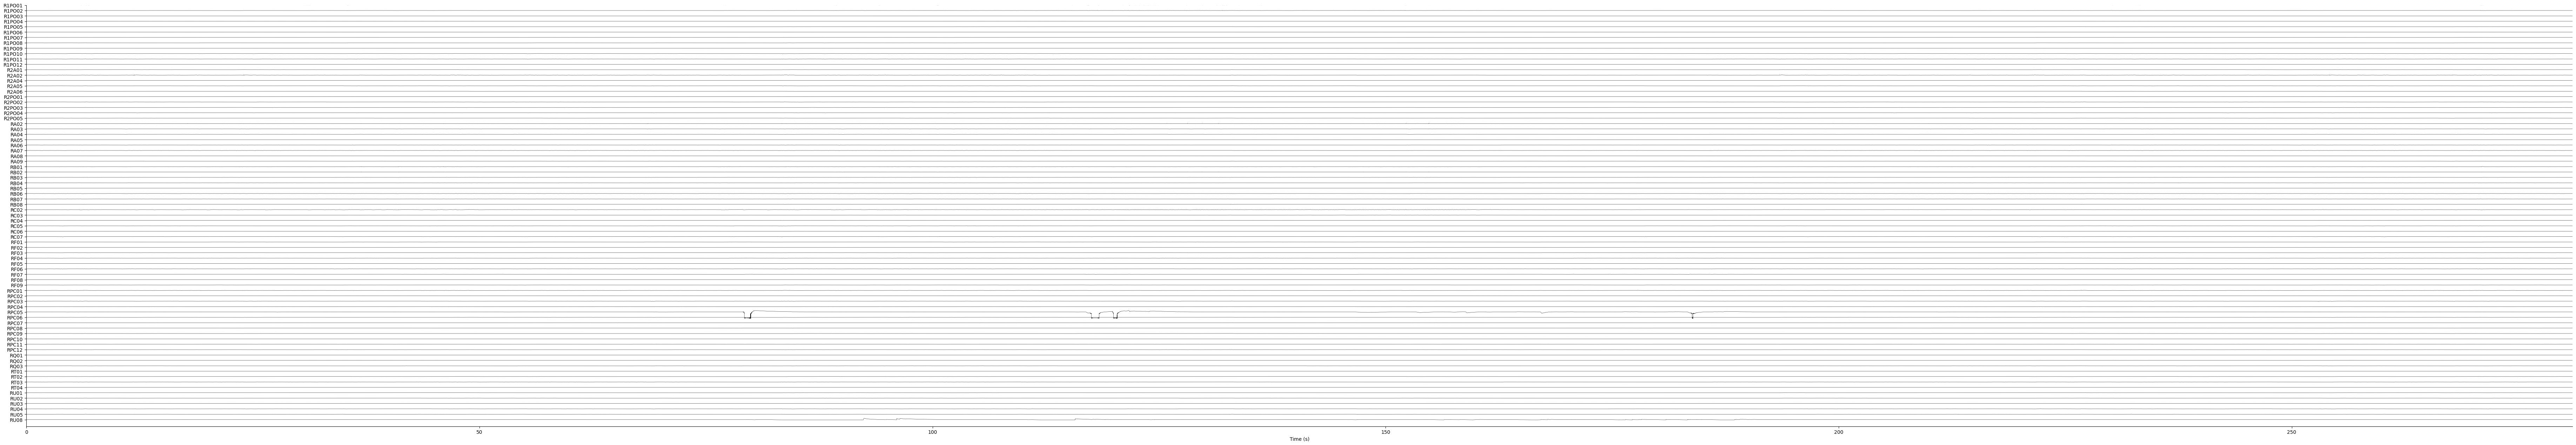

In [16]:
# Filter out bad channels from interictal clip
seizure_neural = seizure_raw[neural_channels]
# seizure_neural.loc[:,:22] = seizure_neural.iloc[:,:22]*1e-3
plot_iEEG_data(seizure_neural,np.arange(len(seizure_neural))/fs_raw)

In [17]:
seizure_prep,fs = preprocess_for_detection(seizure_neural,fs_raw,
                                                wavenet=False,
                                                pre_mask=mask,
                                                target=128)

In [18]:
seizure_prep.shape

(35967, 65)

In [19]:
model.fit(seizure_prep.loc[:fs*30,:])

(<Figure size 9366.15x1300 with 1 Axes>, <Axes: xlabel='Time (s)'>)

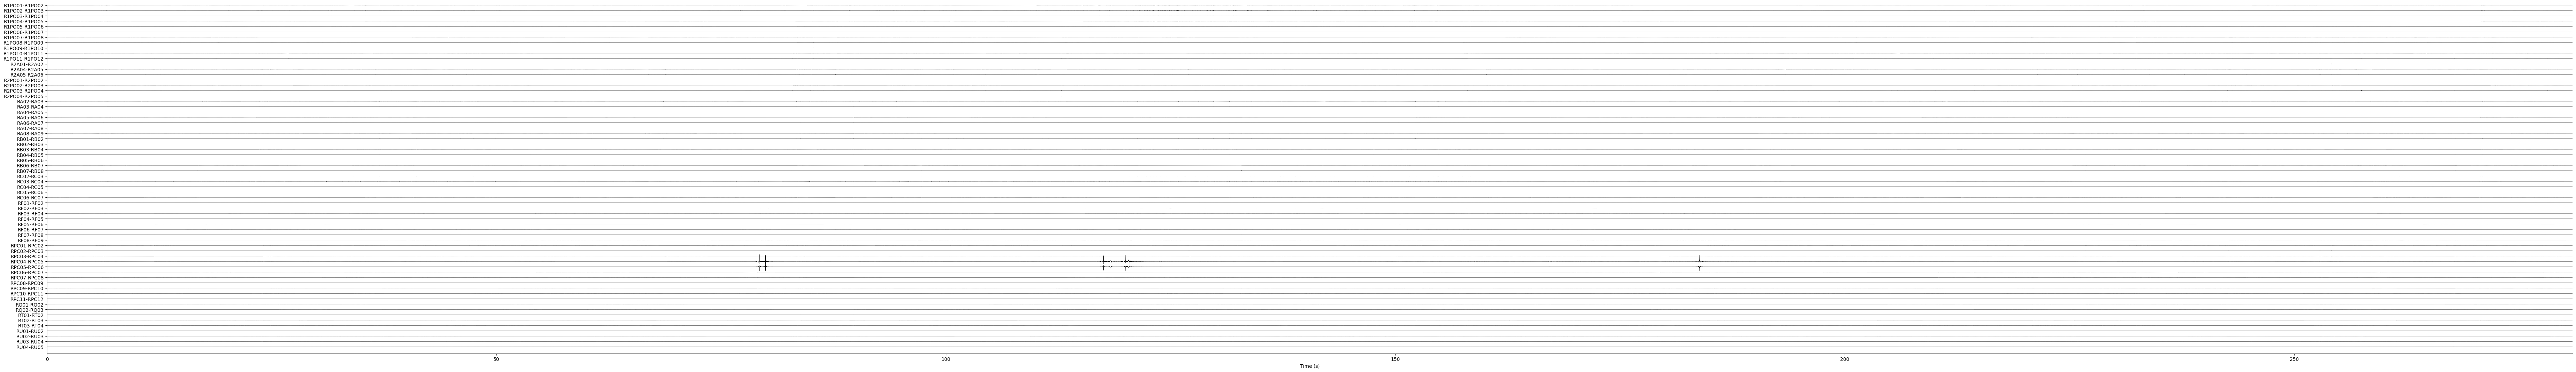

In [20]:
plot_iEEG_data(pd.DataFrame(model.scaler.transform(seizure_prep),columns=seizure_prep.columns),
np.arange(len(seizure_prep))/fs)

([], [])

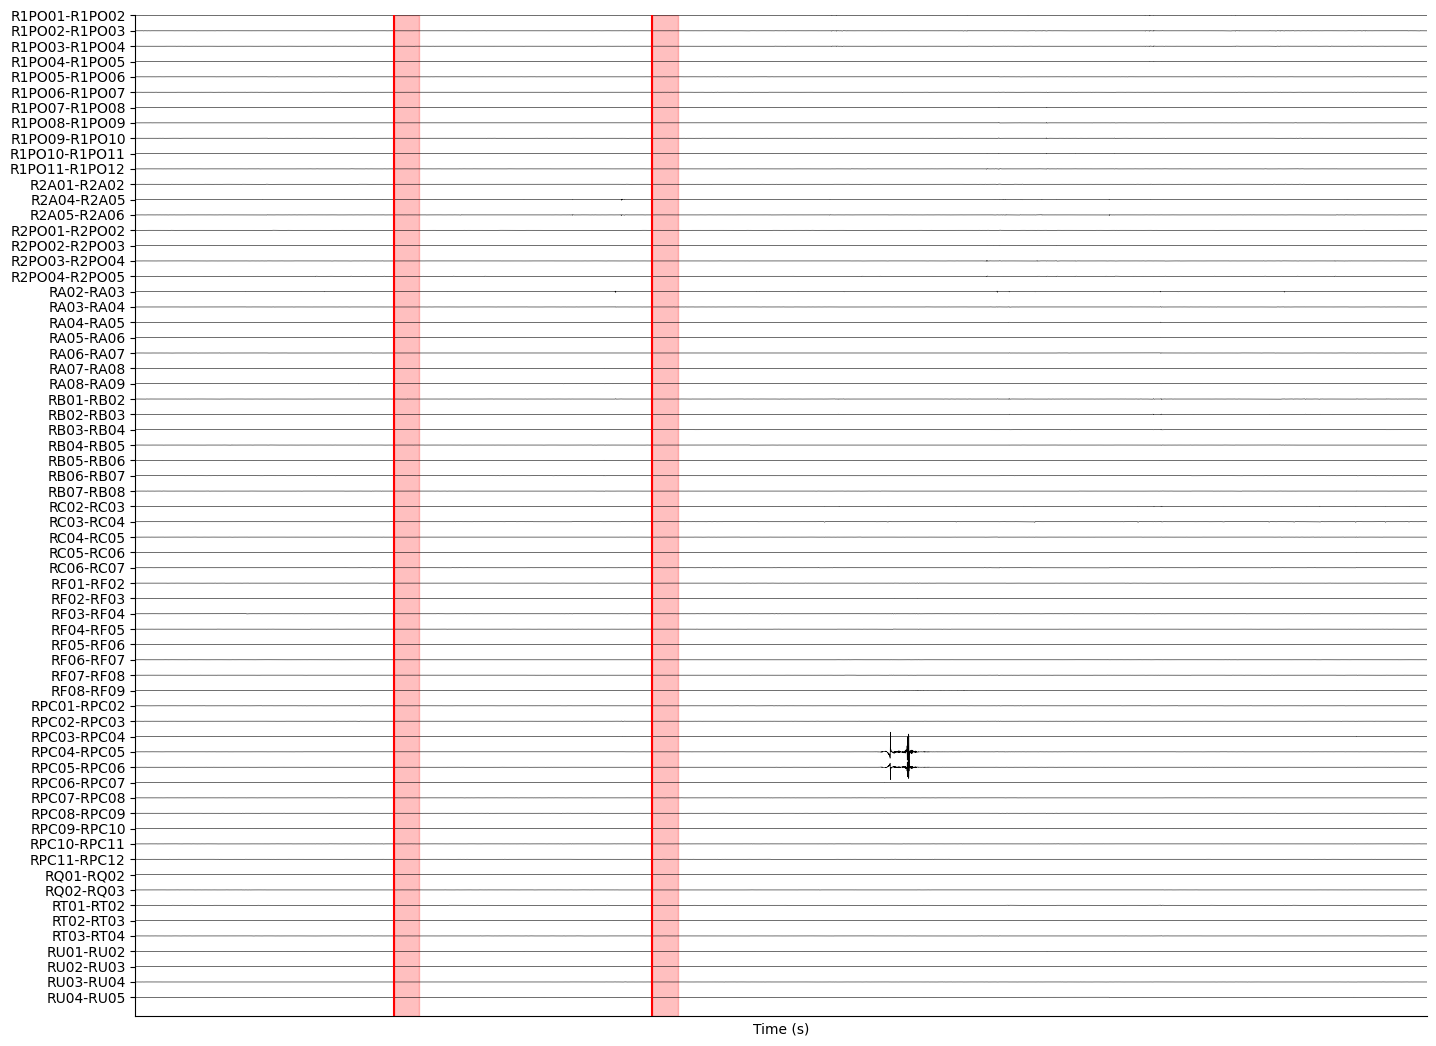

In [21]:
plot_data = pd.DataFrame(model.scaler.transform(seizure_prep),columns=seizure_prep.columns)
plot_time = np.arange(len(seizure_prep))/fs
plot_inds = (plot_time > 50) & (plot_time < 100)
plot_iEEG_data(plot_data.loc[plot_inds,:],plot_time[plot_inds])
plt.axvline(60,color='red')
plt.axvline(70,color='red')
plt.axvspan(60,61,color='red',alpha=0.25)
plt.axvspan(70,71,color='red',alpha=0.25)
plt.xticks([])

(<Figure size 9366.15x1260 with 1 Axes>, <Axes: xlabel='Time (s)'>)

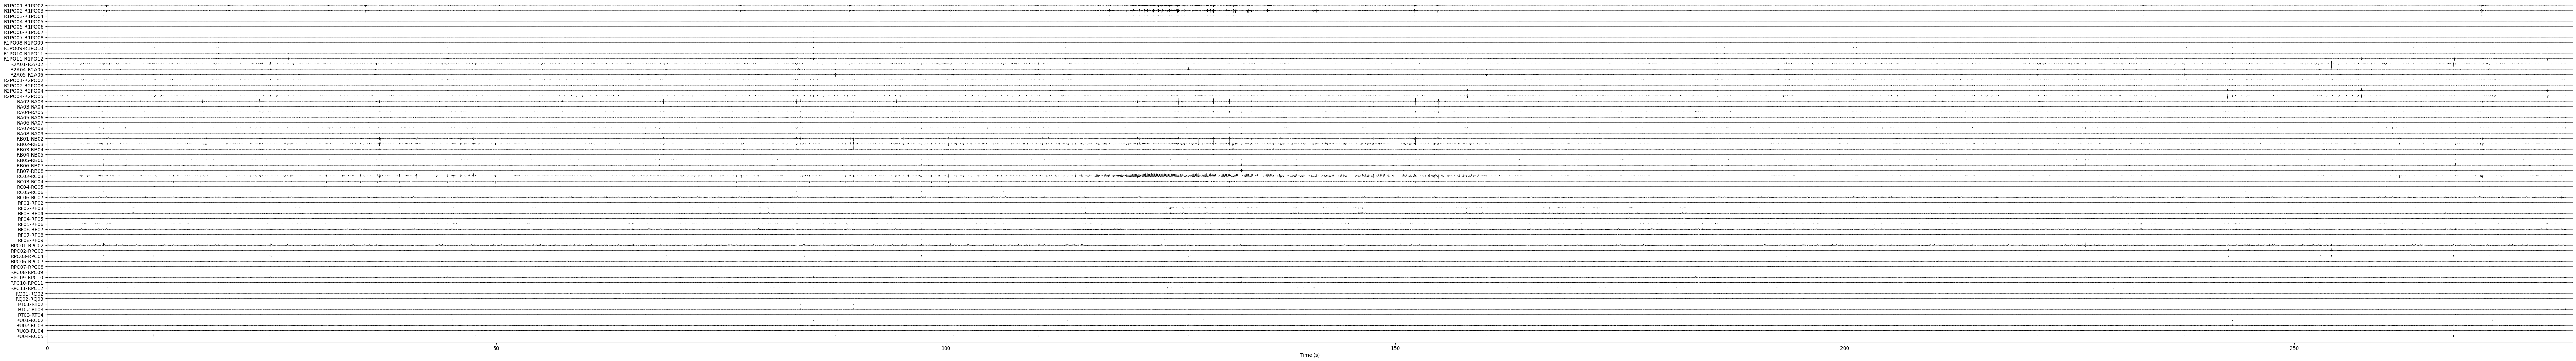

In [22]:
seizure_prep.max()
noisy_channel_mask = seizure_prep.abs().max() <= (np.median(seizure_prep.abs().max())*50)
seizure_prep.columns[~noisy_channel_mask]
plot_iEEG_data(seizure_prep.loc[:,noisy_channel_mask],np.arange(len(seizure_prep))/fs)

In [23]:
preds = model(seizure_prep)
preds_reject = preds[noisy_channel_mask,:]
preds_smooth = sc.ndimage.uniform_filter1d(preds_reject,20,axis=1)

([], [])

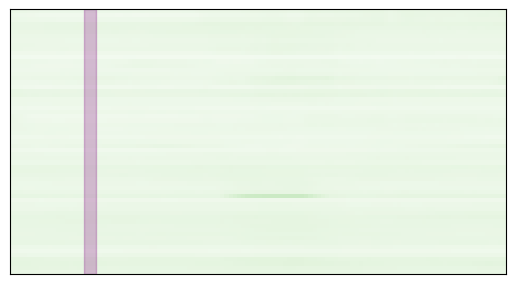

In [24]:
times = model.get_times(seizure_prep)
time_mask = (times > 50) & (times < 110)
plt.imshow(preds_smooth[:,time_mask],cmap='Greens')
plt.clim([0,1])
tiks = np.arange(0,preds_smooth.shape[1],50)
# plt.xticks(tiks,times[tiks].astype(int))
span_start = np.argmin(np.abs(times-10))
plt.axvspan(span_start,span_start+3,alpha=0.25,color='Purple')
plt.xticks([])
plt.yticks([])

In [25]:
ch_mask_early = np.zeros_like(preds_smooth)
ch_mask_late = np.zeros_like(preds_smooth)
ch_mask_all = np.zeros_like(preds_smooth)
early = np.sum(preds_smooth[:,:118] > .2,axis=1) > 30
late = np.sum(preds_smooth[:,-118:] > .2,axis=1) > 30
all_mask = np.sum(preds_smooth > 0.75,axis=1) > preds_smooth.shape[1]/2
ch_mask_early[early,:] = 1
ch_mask_late[late,:] = 1
ch_mask_all[all_mask,:] = 1
# plt.imshow(ch_mask_early)
# plt.figure()
# plt.imshow(ch_mask_late)
# plt.figure()
# plt.imshow(ch_mask_early + ch_mask_late)
# plt.figure()
# plt.imshow(ch_mask_all)

In [26]:
print(seizure_prep.columns[noisy_channel_mask][early])
print(seizure_prep.columns[noisy_channel_mask][late])

Index([], dtype='object')
Index([], dtype='object')


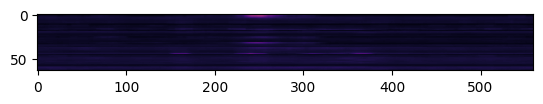

In [27]:
preds_smooth_reject = preds_smooth[~late,:]
plt.imshow(preds_smooth_reject)
plt.clim(0,1)

In [28]:
# onset_chs_list = []
# for t in np.arange(0,1,.01):
#     late = np.sum(preds_smooth[:,-118:] > t,axis=1) > 30
#     preds_smooth_reject = preds_smooth[~late,:]
#     onset_ch_idxs = np.all(preds_smooth_reject[:,118:123]>t,axis=1)
#     sz_chs = seizure_prep.columns[~late]
#     onset_chs = sz_chs[onset_ch_idxs]
#     onset_chs_list.append(onset_chs)

### Unsupervised classification

#### Knee

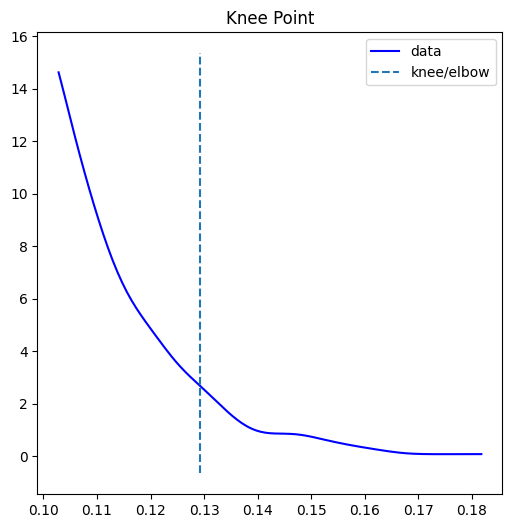

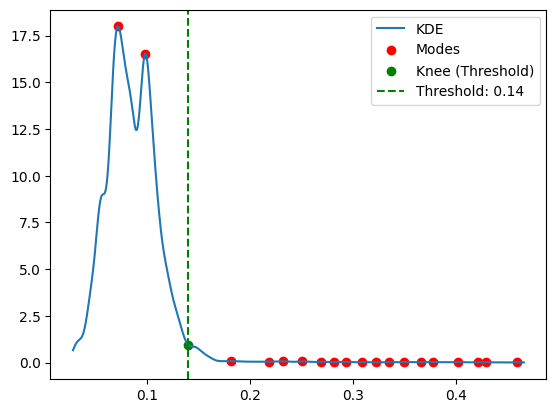

In [29]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
ch_reject = np.zeros((preds_smooth.shape[0],1),dtype=bool)
ch_thresholds = np.zeros((preds_smooth.shape[0],1))
# for ch in range(preds_smooth.shape[0]):
    # Example: Seizing probabilities
probabilities = preds_smooth_reject.flatten()
pk_idx_thresh = np.mean(preds_smooth_reject[58:80,:])
# KDE using scipy's gaussian_kde
kde = gaussian_kde(probabilities,'scott')

# Define an x-axis range to evaluate the KDE
x_vals = np.linspace(min(probabilities), max(probabilities), 1000)
kde_vals = kde(x_vals)

# Find peaks (modes) in the KDE
peaks, _ = find_peaks(kde_vals)

# Find troughs (local minima) between peaks
biggest_pk_idx = np.where(kde_vals[peaks]>(np.mean(kde_vals)+np.std(kde_vals)))[0][-1]
# biggest_pk_idx = np.argmax(kde_vals[peaks])
start, end = peaks[biggest_pk_idx], peaks[biggest_pk_idx+1]
# trough_idx = np.argmin(kde_vals[start:end]) + start
trough_idx = int((end-start)/2 + start)
# trough_idx = np.argmin(fit_mdl(x_vals))
threshold = x_vals[int(trough_idx)]

kneedle = KneeLocator(x_vals[start+10:end],kde_vals[start+10:end],
                      curve='convex',direction='decreasing',interp_method='polynomial')
kneedle.plot_knee()
# threshold = kneedle.knee
# print(f"{seizure_prep.columns[ch]} Threshold between modes: {threshold}")
plt.figure()
# # Plot the results
plt.plot(x_vals, kde_vals, label="KDE")
plt.scatter(x_vals[peaks], kde_vals[peaks], color='red', label="Modes")
plt.scatter(x_vals[trough_idx], kde_vals[trough_idx], color='green', label="Knee (Threshold)")
plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.legend()
plt.show()

In [30]:
print(np.mean(kde_vals),np.var(kde_vals))

2.2763912787836738 22.496451526316662


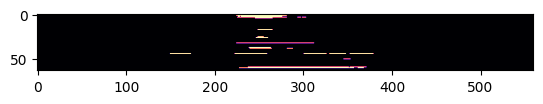

In [31]:
plt.imshow(preds_smooth>threshold)

### Gamma

In [42]:
from scipy.stats import gamma

# Step 1: Fit Gamma distribution to interictal data
def fit_gamma(interictal_data):
    shape, _, scale = gamma.fit(interictal_data, floc=0)  # force location to 0
    return shape, scale

# Step 2: Calculate the confidence value for a given loss
def confidence_outside_distribution(loss_value, shape, scale):
    # Calculate the CDF for the given loss value
    cdf_value = gamma.cdf(loss_value, a=shape, scale=scale)
    
    # Confidence value that the loss is outside the interictal distribution
    confidence_outside = cdf_value
    return confidence_outside

def get_95_confidence_threshold(shape, scale):
    # Get the loss value at the 95th percentile using the PPF (percent point function)
    threshold_value = gamma.ppf(0.95, a=shape, scale=scale)
    return threshold_value
 
# Example usage
loss_value = preds_smooth[4,:] # Example new loss value

# Fit Gamma distribution to interictal data
shape, scale = fit_gamma(loss_value)

# Calculate the confidence for the given loss value
confidence = confidence_outside_distribution(loss_value, shape, scale)

# print(f"Confidence that the loss value {loss_value} is outside the interictal distribution: {confidence:.4f}")

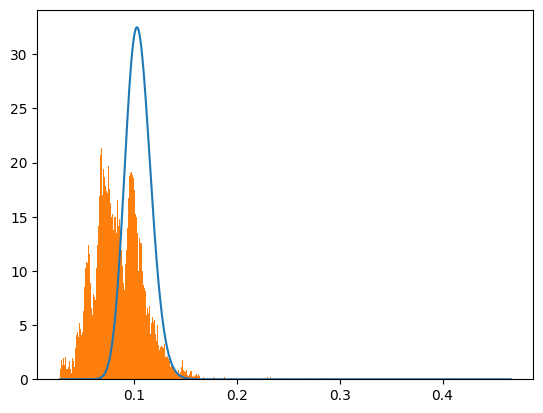

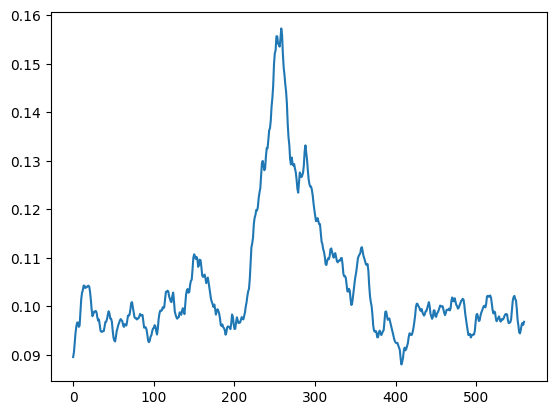

In [43]:
x_plot = np.linspace(np.min(preds_smooth),np.max(preds_smooth),1000)
plotting_pdf = sc.stats.gamma.pdf(x_plot,a=shape,scale=scale)
plt.plot(x_plot,plotting_pdf);
plt.hist(preds_smooth.flatten(),density=True,bins=1000);
plt.figure()
plt.plot(loss_value.T)

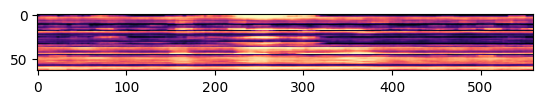

In [131]:
plt.imshow(confidence.reshape(preds_smooth.shape))

In [44]:
plt.imshow(confidence.reshape(preds_smooth.shape)>0.95)

ValueError: cannot reshape array of size 560 into shape (63,560)

In [36]:
threshold_value = gamma.ppf(0.95, a=shape, scale=scale)
threshold_value

0.13427709078381161

### Measuring dynamic spread

In [42]:
# To save
# First seizing index at the final threshold after offset
# UEO channels at first seizing index + 3 indices
# Seizing index and time since first seizing index for each channel
time_wins = model.get_times(seizure_prep)
t = threshold
late = np.sum(preds_smooth[:,-120:] > t,axis=1) > 30
preds_smooth_reject = preds_smooth[~late,:]
sz_chs = seizure_prep.columns[~late]
first_sz_idx_offset = 118
sz_clf_final = preds_smooth_reject > t
# Get channels
sliced_data = sz_clf_final[:,first_sz_idx_offset:]
df = pd.DataFrame(sliced_data).T
seizing = df.rolling(window=3,closed='right').apply(lambda x: (x == 1).all())
first_sz_idxs = seizing.idxmax().to_numpy() - 2
seized_idxs = np.any(sliced_data,axis=1)
first_sz_idxs += first_sz_idx_offset
if sum(seized_idxs) > 0:
    sz_times_arr = time_wins[first_sz_idxs[seized_idxs]]
    sz_times_arr -= np.min(sz_times_arr)
    sz_ch_arr = sz_chs[seized_idxs]
    sz_ch_arr = np.array([s.split("-")[0] for s in sz_ch_arr]).flatten()
else:
    sz_ch_arr = []
    sz_times_arr = []

IndexError: boolean index did not match indexed array along dimension 0; dimension is 94 but corresponding boolean dimension is 90

In [43]:
time_wins[first_sz_idxs[seized_idxs]]

NameError: name 'first_sz_idxs' is not defined

In [72]:
print(time_wins[118],time_wins[140])

60.0 71.0


In [73]:
idxs = np.argsort(sz_times_arr)
print(sz_ch_arr[idxs])

['RA01' 'RB02' 'RC01' 'RB01' 'RA02' 'RA03' 'RA04' 'RA05' 'RC02' 'RT01'
 'RI01' 'RI02' 'RT05' 'RF04' 'RF05']


Text(0.5, 1.0, 'Seizure spread after onset')

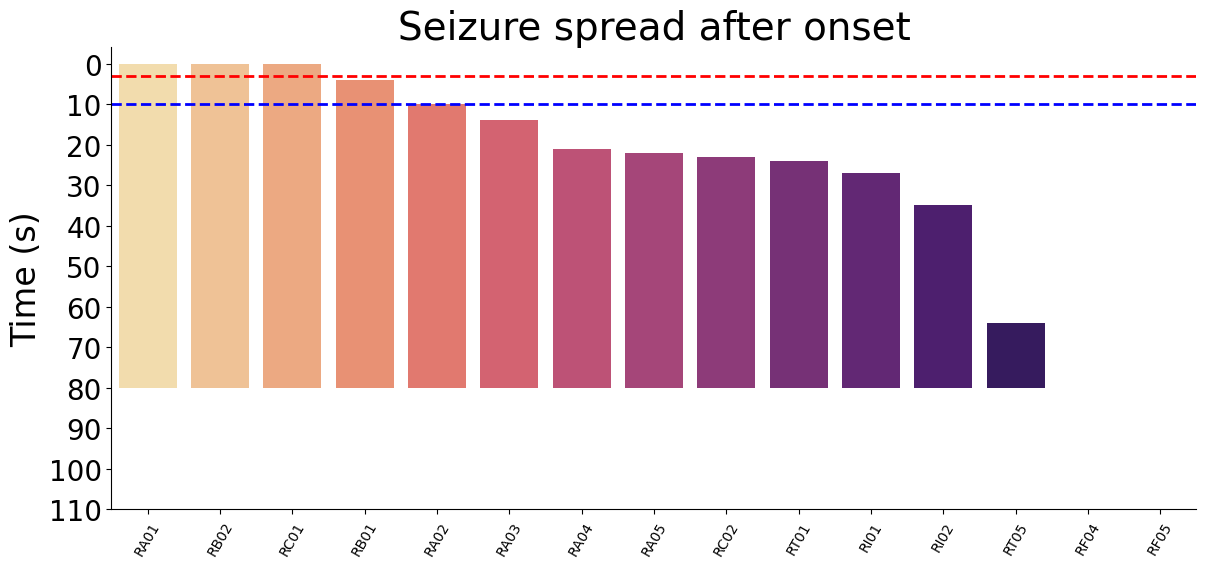

In [74]:
plt.figure(figsize=(14,6))
# plt.bar(np.arange(len(idxs)),sz_times_arr[idxs],color='green')
plot_times_arr = max(sz_times_arr) - sz_times_arr
sns.barplot(x=np.arange(len(idxs)),y=plot_times_arr[idxs],palette='magma_r',orient='v')
sns.despine()
plt.xticks(np.arange(len(idxs)),sz_ch_arr[idxs],rotation=60)
t = plt.yticks()
y_tix = max(sz_times_arr) - np.arange(0,120,10)
plt.yticks(y_tix,np.arange(0,120,10),fontsize=20)
plt.axhline(max(sz_times_arr)-3,ls='--',color='red',linewidth=2)
plt.axhline(max(sz_times_arr)-10,ls='--',color='blue',linewidth=2)
plt.ylabel("Time (s)",fontsize=24)
plt.title('Seizure spread after onset',fontsize=28)

## Deep Learning

In [28]:
 # Instantiate the model
input_size = inter_prep.shape[1]
hidden_size = 10

# Check for cuda
# ccheck = torch.cuda.is_available()
ccheck = False

# Initialize the model
model = LSTMModel(input_size, hidden_size)

# Scale the training data
model.fit_scaler(inter_prep)
inter_z = model.scaler_transform(inter_prep)
inter_z = pd.DataFrame(inter_z,columns=inter_prep.columns)

# Prepare input and target data for the LSTM
input_data,target_data = prepare_segment(inter_z,fs=fs)

dataset = TensorDataset(input_data, target_data)
full_batch = len(dataset)
dataloader = DataLoader(dataset, batch_size=full_batch, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model, this will just modify the model object, no returns
# print("Training patient specific model")
train_model(model,dataloader,criterion,optimizer,ccheck=ccheck)

# Creating classification thresholds
input_data,target_data = prepare_segment(inter_z,fs=fs)
inter_outputs = predict_sz(model,input_data,target_data,batch_size=full_batch,ccheck=ccheck)
thresholds = np.percentile(inter_outputs,75,0)

In [29]:
seizure_z = model.scaler_transform(seizure_prep)
seizure_z = pd.DataFrame(seizure_z,columns=seizure_prep.columns)
input_data, target_data,time_wins = prepare_segment(seizure_z,fs,12,1,ret_time=True)
# Generate seizure detection predictions for each window
outputs = predict_sz(model,input_data,target_data,batch_size=len(input_data)//2,ccheck=ccheck)
seizure_mat = repair_data(outputs,seizure_z,fs=fs)
# Getting raw predicted loss values for each window
raw_sz_vals = np.mean(np.log(seizure_mat),1).T
# Creating classifications
mdl_outs = (raw_sz_vals.T > np.log(thresholds)).T.astype(float)

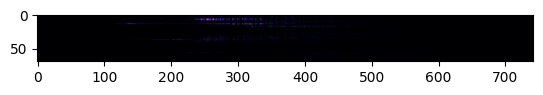

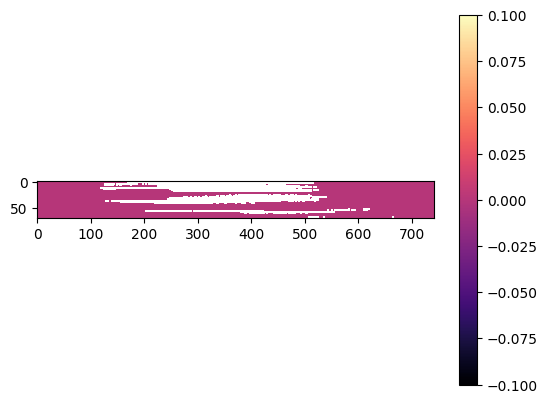

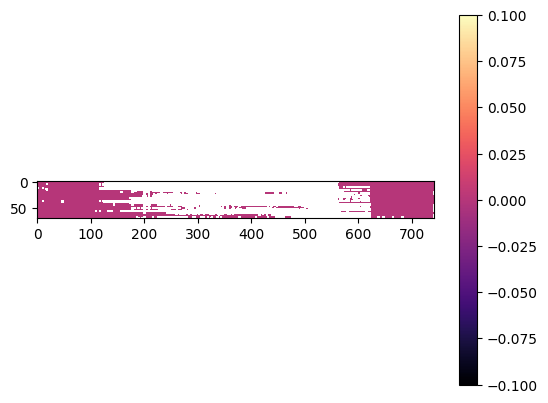

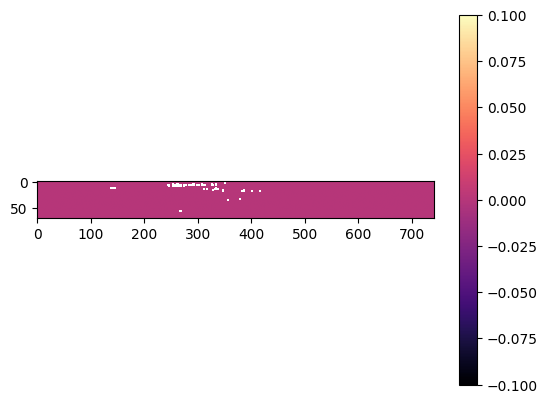

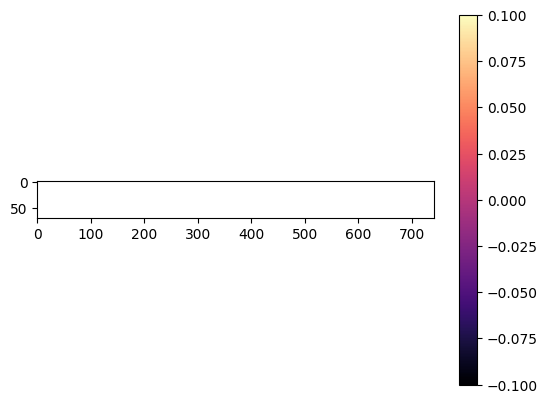

In [49]:
plt.figure()
plt.imshow(np.median(seizure_mat,1).T)
plt.figure()
temp = np.exp(np.mean(seizure_mat,1).T)
plt.imshow(temp/np.max(temp))
plt.colorbar()
plt.figure()
temp = np.mean(np.exp(seizure_mat),1).T
plt.imshow(temp/np.max(temp))
plt.colorbar()
plt.figure()
temp = np.exp(np.percentile(seizure_mat,75,axis=1).T)
plt.imshow(temp/np.max(temp))
plt.colorbar()
plt.figure()
temp = np.percentile(np.exp(seizure_mat),75,axis=1).T
plt.imshow(temp/np.max(temp))
plt.colorbar()

## Plotting heatmaps

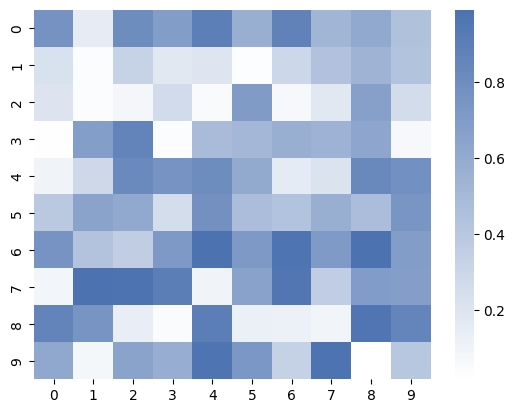

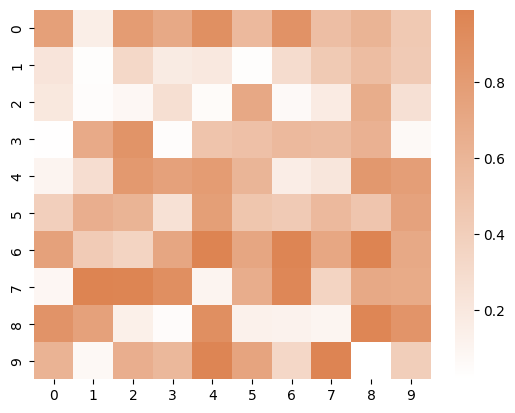

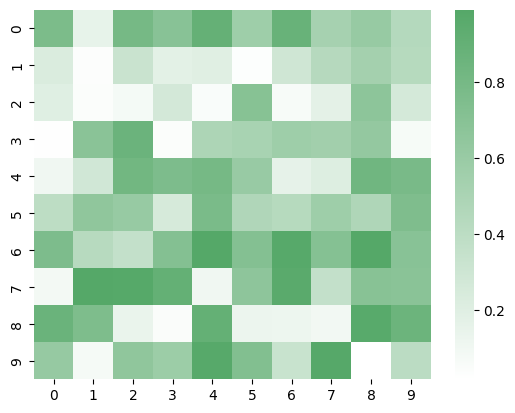

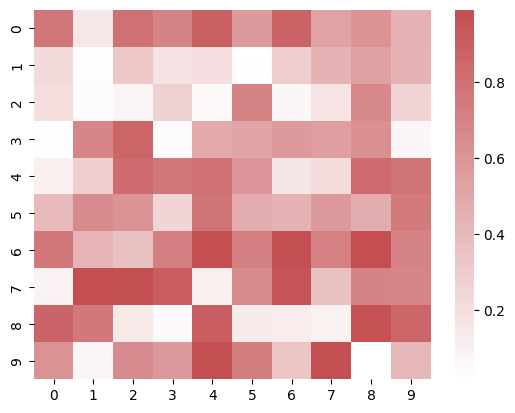

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = sns.color_palette("deep", 4)
data = np.random.rand(10, 10)

# Get the first 4 colors from the default seaborn color palette
colors = sns.color_palette("deep", 4)
# Plot heatmaps for the first 4 colors
for color in colors:
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [(1, 1, 1), color])
    sns.heatmap(data, cmap=cmap)
    plt.show()

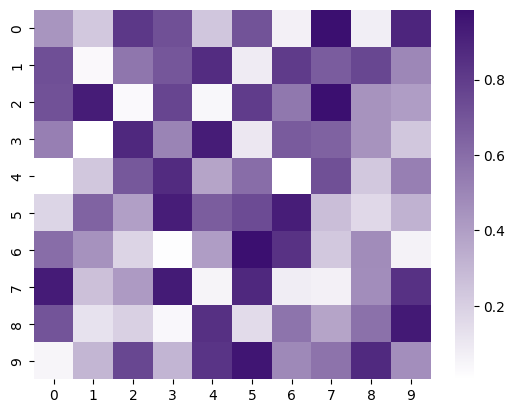

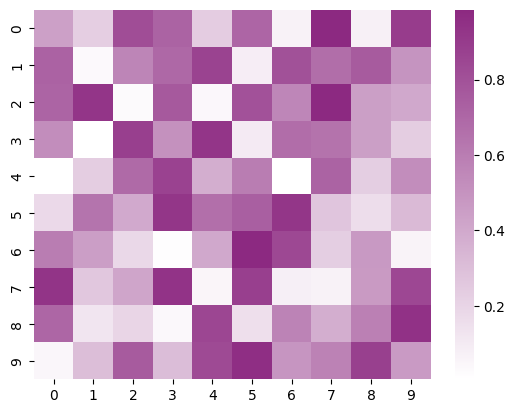

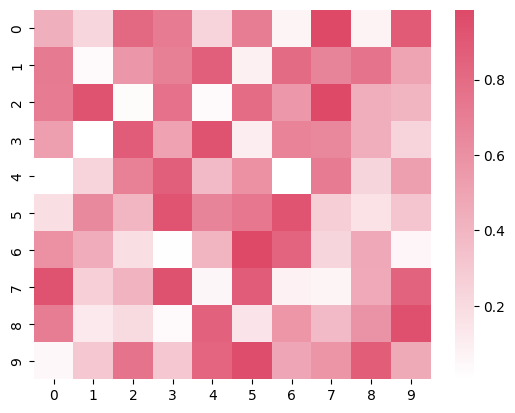

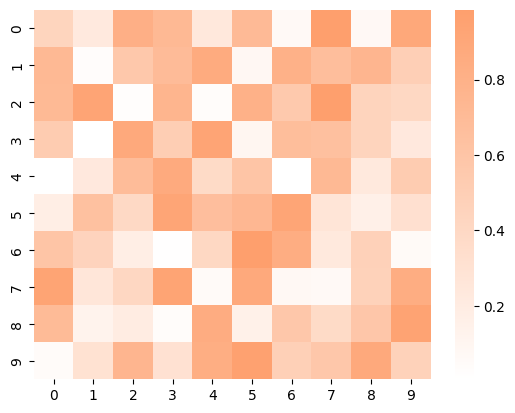

In [100]:
from matplotlib.colors import LinearSegmentedColormap
colors = sns.color_palette("magma", 4)
data = np.random.rand(10, 10)

# Get the first 4 colors from the default seaborn color palette
colors = sns.color_palette("magma", 4)
# Plot heatmaps for the first 4 colors
for color in colors:
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [(1, 1, 1), color])
    sns.heatmap(data, cmap=cmap)
    plt.show()

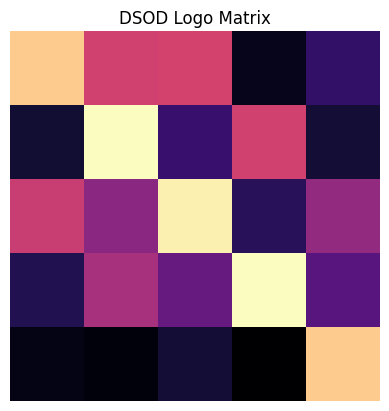

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Set matrix size and initialize with Gaussian noise
matrix_size = 5  # Adjust this based on how large you want the matrix
matrix = np.random.uniform(size=(matrix_size, matrix_size))

# Define diagonal elements to form the "DSOD" pattern
# Let's manually increase the values on the diagonal to spell DSOD
# You can adjust these positions and values as needed
letters = ['D', 'S', 'O', 'S', 'D']
ascii_values = np.array([ord(char) for char in letters])  # Use ASCII values to represent letters
ascii_values = (ascii_values-min(ascii_values))/max(ascii_values)+1.5

# Place letters along the diagonal (enhanced values to make them stand out)
for i in range(len(letters)):
    matrix[i, i] = ascii_values[i]  # Adjust intensity

# Plot the matrix with the magma palette
plt.imshow(matrix, cmap='magma', norm=Normalize(vmin=matrix.min(), vmax=matrix.max()))
plt.title('DSOD Logo Matrix')

# Hide the axis for aesthetics
plt.axis('off')

# Save or display the image
plt.savefig('dsod_logo.png', dpi=300)
plt.show()